# Community Detection in Urban Networks
---

Visuaization of communities in an Urban Network, this is some experimentation as part of my [PhD research on Multilayer Urban Networks](https://networkdatascience.ceu.edu/node/435), at the [Department of Network and Data Science](https://networkdatascience.ceu.edu/) (Central European University, Budapest).

The code uses [OSMnx](https://osmnx.readthedocs.io/en/stable/) a Python Package to 'retrieve, construct, analyze, and visualize street networks from OpenStreetMap.'

For more information feel free to contact me natera_luis@phd.ceu.edu

## Imports

In [1]:
import networkx as nx
import time
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
from networkx.algorithms import community
import community as louvain
import matplotlib.cm as cm
import matplotlib.colors as mpcol
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon


%matplotlib inline

In [2]:
ox.config(data_folder='data', logs_folder='logs', 
          imgs_folder='imgs', cache_folder='cache', 
          use_cache=True, log_file=True, log_console=True)

## Download the data

In [3]:
G_drive = ox.graph_from_place('Guadalajara, Mexico', network_type='drive', simplify=True, which_result=2)
G_drive = ox.project_graph(G_drive)

## Undirected network
I'm using the Louvain method for community detection, the networkx implementation works with undirected networks.

In [4]:
def undirected_network(G):
    G_simple = nx.Graph()
    for i,j,data in G.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G_simple.has_edge(i,j):
            G_simple[i][j]['weight'] += w
        else:
            G_simple.add_edge(i,j,weight=w)
    return G_simple

In [5]:
G_simple = undirected_network(G_drive)

## Community detection
I used the networkx implementation for the Louvain algorithm. the function returns a dictionary of the nodes as keys and the community as values, this will be used to assign the community for each node in the G_drive network.

In [6]:
def find_communities(G):
    start_time = time.time()
    partition = louvain.best_partition(G)
    part_dict = {}
    values = []
    for node in G.nodes():
        values.append(partition.get(node))
        part_dict.update({node:partition.get(node)})
    communities_louvain= max(values)+1
    end_time = time.time()
    mod_louvain = louvain.modularity(partition,G_simple)
    print('Communities found using the Louvain algorithm: {} \nModularity: {} \nTime for finding the communities: {} s'.format(communities_louvain, mod_louvain,round((end_time-start_time),3)))
    return part_dict

In [7]:
part_dict = find_communities(G_simple)

Communities found using the Louvain algorithm: 62 
Modularity: 0.9549808726770614 
Time for finding the communities: 4.03 s


## Set the community attribute to the nodes
Also I got a list of the communities of the nodes, this will be use to map the colors

In [8]:
#Set the node attributes ussing the partition dictionary.
nx.set_node_attributes(G_drive, part_dict, 'community')

# Get a list of len(nodes) with their corresponding community
communities = [(G_drive.nodes()[i]['community']) for i in G_drive.nodes()]

## Get the colors
I used colors inspired in Luis Barragán's work 
<img src="Barragan.png">

In [9]:
#List of color
Color_barragan = ['#E1CF3F','#F47757','#FD4581','#97577C','#BDA7A9','#E1CF3F','#F47757','#FD4581',
                 '#e44623','#e45a6a','#c9d3e6','#7d513d',
                 '#e65949','#d6b240','#382a29','#d8d4c9',
                 '#e4cc34','#ccb42c','#bc8ca4','#3c84c4',
                 '#dd4d3d','#52172f','#63494a','#e2d5d3',
                 '#f7abcc','#e085a1','#943d39','#2d1d19']
#Create the color map
Barragan = mpcol.ListedColormap(Color_barragan, name='Barragan')

In [10]:
com = [x[1] for x in G_drive.nodes(data='community')]
norm = mpcol.Normalize(vmin=min(com), vmax=max(com), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=Barragan)
nc=[mapper.to_rgba(x) for x in com]

## Plot the network

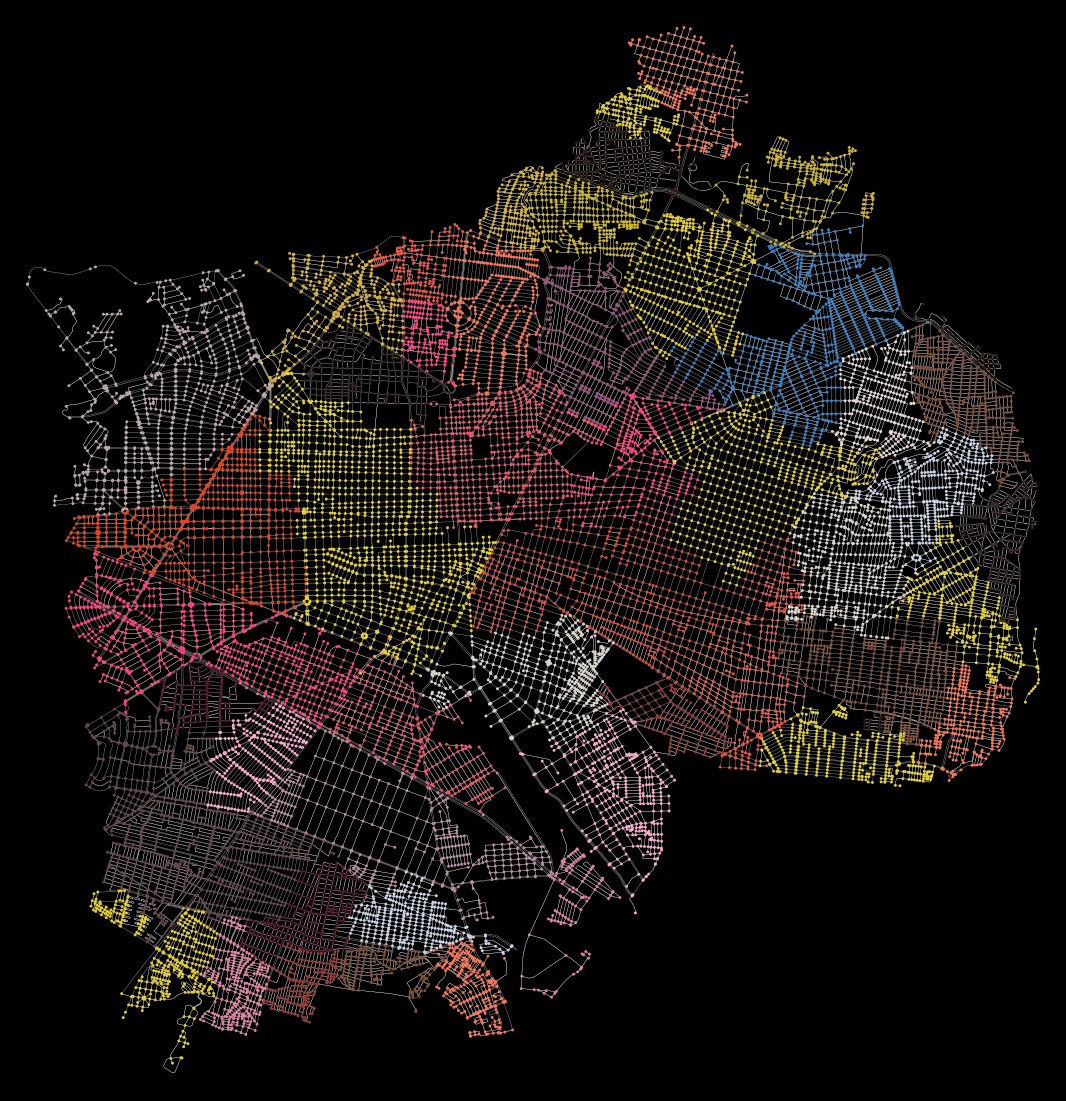

In [11]:
save = False
name = 'Guadalajara'
fig, ax = ox.plot_graph(G_drive, bgcolor='black', node_color=nc, node_size=8.5, node_zorder=3, node_alpha=1, 
                        edge_linewidth=0.25, edge_color='white',edge_alpha=1,fig_height=20,close=True, show=True, 
                         save=save, filename=name,file_format='png')

## Plot over the neighborhoods.
I wanted to see if there is some relation between the neighborhoods and the network structure, so I imported the neighborhoods and plot them under the network to see how the communities match (or not) the administrative partition of the city.

In [12]:
# Import the neighborhoods geojson
gdf = gpd.GeoDataFrame.from_file('colonias.geojson')

### Plot the network and close it

In [13]:
fig, ax = ox.plot_graph(G_drive, node_color=nc, node_size=17, node_zorder=3, node_alpha=1, 
                        edge_linewidth=0.25, edge_color='lightblue',edge_alpha=1,fig_height=20,close=False, show=False)
plt.close()

### Get the face color for each neighborhood 

In [14]:
geom = gdf['geometry'].tolist()
pol = [x for x in range(len(geom))]
norm = mpcol.Normalize(vmin=min(pol)+2, vmax=max(pol)+1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.gray)
colors=[mapper.to_rgba(x) for x in pol]

Add each neighborhood as a patch to the ax, each one of the newighborhoods will have a different color.

In [15]:
for geometry, color in zip(gdf['geometry'].tolist(), colors):
    patch = PolygonPatch(geometry, fc=color, ec='white', linewidth=2, alpha=0.7, zorder=-1)
    ax.add_patch(patch)

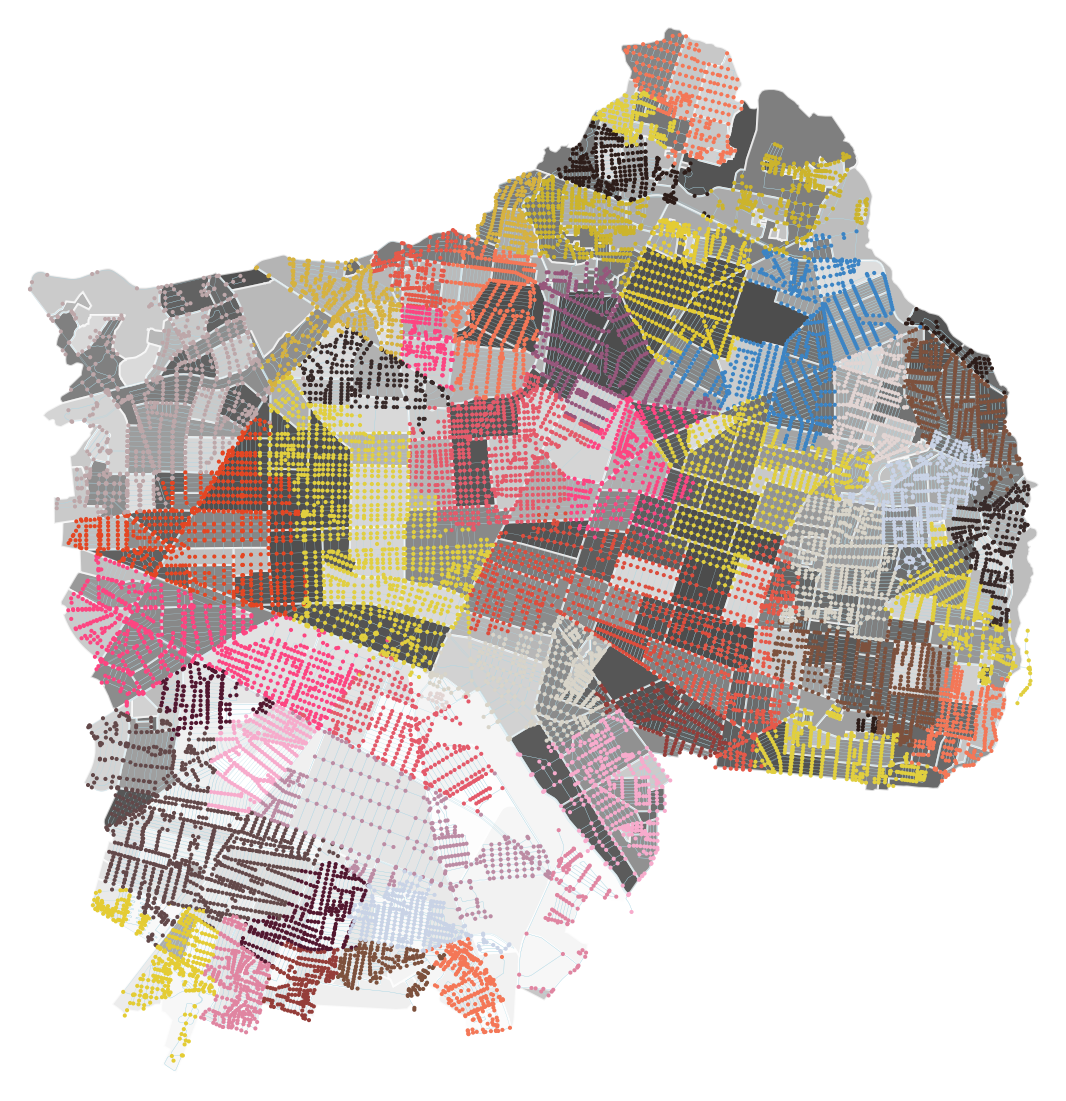

In [16]:
margin = 0.02
west, south, east, north = gdf.unary_union.bounds
margin_ns = (north - south) * margin
margin_ew = (east - west) * margin
ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))
fig